# MV4QC Case 3: Inline lengtebepaling van vissen per soort
In deze notebook wordt het ontwikkelde algortime verduidelijkt om vis te detecteren, classificeren en te meten. Er wordt gebruik gemaakt van een netwerk die reeds getraind is op 839 afbeeldingen van 10 soorten vis. Het gebruikte model is Resnet34.

#1 Voorbereiding
Om de code juist uit te voeren zijn er enkele voorbereidende stappen nodig. Run de onderstaande code om de omgeving juist klaar te zetten.

In [69]:
# Mount Google drive to Google Colab
from google.colab import drive
drive.mount('/content/drive')

# Go to My Drive folder
%cd /content/drive/MyDrive/Masterproef_Notebook


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Masterproef_Notebook


In de onderstaande stap worden de nodige libraries geinstaleerd. Deze zullen nodig zijn voor de werking van het programma. Run de onderstaande code om deze stap uit te voeren. 

In [70]:
!pip install -r '/content/drive/MyDrive/Masterproef_Notebook/Essential_files/requirements.txt'
!pip install segment_anything
!pip install keyboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-pjc6_ljk
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-pjc6_ljk
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Using cached av-10.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (31.0 MB)
  Using cached ffmpy-0.3.0.tar.gz (4.8 kB)
  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/si

Vervolgens zullen de libraries worden geimporteerd. Ook zullen een aantal hulpfuncties worden ingeladen doormiddel van een python file. Run de onderstaande code om de stap uit te voeren.

In [71]:
import cv2,random,torch,math,time,os,keyboard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import models
from skimage.morphology import skeletonize
from segment_anything import SamPredictor, sam_model_registry
from PIL import Image
from google.colab.patches import cv2_imshow
from skimage import io

%run -i /content/drive/MyDrive/Masterproef_Notebook/Essential_files/module.py


In de code zal er gebruik gemaakt worden van SAM of Segment Anything Model. Dit is een model ontwikkeld door Meta die getraind is een groot aantal afbeeldingen om delen hiervan te segmenteren. Het unieke aan SAM is dat deze geleerd heeft wat een algemeen "object" is. De code hieronder zal SAM initialiseren om deze later in de code te gebruiken. Deze stap kan even tijd in beslag nemen omdat er zonder GPU gewerkt wordt.

In [72]:
#Initialize SAM
sam = sam_model_registry["vit_h"](checkpoint="/content/drive/MyDrive/Masterproef_Notebook/Essential_files/sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)

In deze demo is er keuze tussen 2 Resnet modellen. De ene is getraind op afbeeldingen met een hogere resolutie dan de andere. Hierdoor noemen deze BestHD2 en BestLD2. Maak een keuze in het onderstaande stuk code door de variabel model_name gelijk te stellen aan "BestLD2" of "BestHD2" en de code te runnen. Het HD model zal betere maar tragere resultaten leveren in vergelijking met het LD model.

In [73]:
#Choice of model

model_name = "BestLD2"

model = torch.load("/content/drive/MyDrive/Masterproef_Notebook/Models/" + model_name + ".pt",map_location=torch.device('cpu'))

#2 Afbeelding verwerken
In deze demo zijn een aantal test afbeeldingen verwerkt. Hier kan er een keuze gemaakt worden tussen deze verschillende afbeeldingen. Dit kan gedaan worden door de variabel image_name gelijk te stellen aan "image1", "image2" of "image3. In deze stap wordt de afbeelding ingelezen in de code voor verder gebruik.

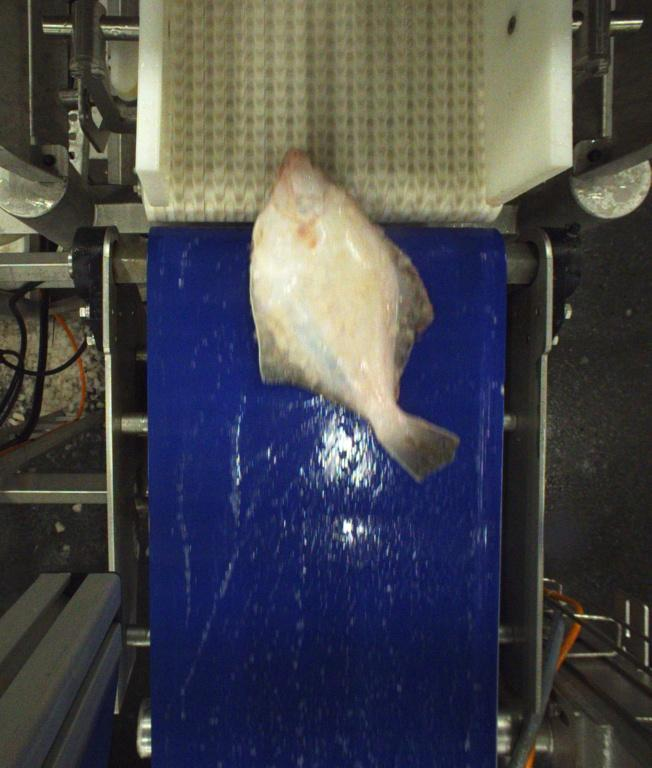

In [74]:
#Preview image

image_name = "image2"

images_dir = "/content/drive/MyDrive/Masterproef_Notebook/Test Images/"
img = read_image(images_dir + image_name + ".jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2_imshow(img)

In deze stap zal de afbeelding worden geschaald om overeen te komen met het getrainde model. 
Als er een HD model gekozen is, stel de variabel image_size dan gelijk aan 500. Als er een LD model gekozen is, stel de variabel image_size dan gelijk aan 300.
De afbeelding zal worden geschaald en opgeslagen voor verder gebruik.

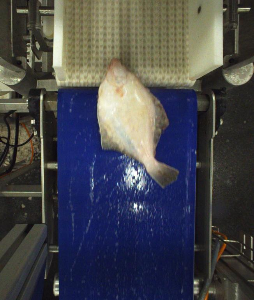

In [75]:
#Resize image to fit model 
image_size = 300

resized_path = "/content/drive/MyDrive/Masterproef_Notebook/Test Images/images_resized/"
height, width, depth = img.shape
aspect_ratio = width/height
img = cv2.resize(img, (int(aspect_ratio*image_size), image_size))
cv2.imwrite(resized_path + image_name + '.jpg', img)
cv2_imshow(img)

Het model verwacht de data te ontvangen in de vorm van een genormaliseerde dataset structuur. Run de code om deze stap uit te voeren.

In [76]:
#Setup dataset for model
test_ds = Dataset(pd.DataFrame([{'path':image_name + '.jpg'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]
xx = torch.FloatTensor(x[None,])

#3 Detectie en classificatie
Hier worde de detectie en classificatie zelf uitgevoerd. Het model krijgt de dataset en maakt een voorspelling over waar de vis te zien is en welke soort deze is. Vervogens wordt er een rode bounding box getrokken rond deze regio en wordt de soort geprint. De soort is de faocode van de soort vis. Dit is een codering om elke vissoort met 3 letters weer te geven. Run de code om deze stap uit te voeren

[ 42  93 168 176] PLE


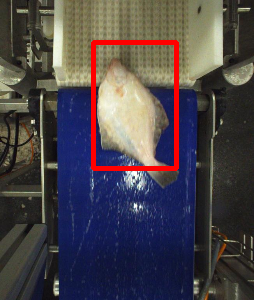

In [77]:
#Prediction of bounding box and class
class_list = ["PLE","GUU","WIT","BIB","SOL","ANF","GUR","MEG","HAD","WHG"]

out_class, out_bb = model(xx)
_, class_pred = torch.max(out_class, 1)
bb = out_bb.detach().cpu().numpy()[0]
bb = bb.astype(int)
print(bb,class_list[class_pred])

detection = cv2.rectangle(img, (bb[1], bb[0]), (bb[3], bb[2]), (0, 0, 255), 3)
cv2_imshow(img)

#4 Lengtebepaling

Nadat de bounding box rond de vis bekend is, zal de afbeelding gecropt worden naar deze regio. Hierin zal een punt berekend worden in het midden van de bounding box. Dit punt zal de invoer zijn voor SAM. SAM zal een mask genereren waar de vis te zien is. Vervolgens zal deze mask worden geblurd en gethreshold om een smooth vorm te genereren. Deze stap kan wat tijd in beslag nemen aangezien er gewerkt wordt zonder GPU. (~2 min)

image cropped
mask generated
mask blurred and thresholded


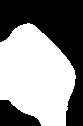

In [78]:
#Cropping image and generating mask with SAM

img = img[bb[0]:bb[2], bb[1]:bb[3]]
print("image cropped")
predictor.set_image(img)
height, width, _ = img.shape
input_point = np.array([[width // 2, height // 2]])   #Point in the middle of the bounding box
point_label = np.array([1])
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=point_label,
    multimask_output=False,
)
print("mask generated")
mask = (masks[0].astype(float))
mask = TF_to_image(mask)

# BLURRING AND THRESHOLDING MASK
blurwidth = 30
thresh = 100
mask = cv2.blur(mask, (blurwidth, blurwidth))
mask = cv2.threshold(src=mask, thresh=thresh, maxval=255, type=cv2.THRESH_BINARY)[1]
print("mask blurred and thresholded")
cv2_imshow(mask)


In de volgende stap worden bovenste en onderste punten gevonden waar de mask te zien is. Deze punten worden aangeduid met een groene stip op de mask. Run de code om deze stap uit te voeren.

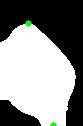

In [79]:
# Finding top and bottom pixel of mask
top_pixel = find_top_pixel(mask)
bottom_pixel = find_bottom_pixel(mask)
mask_anotated = mask.copy()
cv2.circle(mask_anotated, top_pixel, 3, (0, 255, 0), -1)
cv2.circle(mask_anotated, bottom_pixel, 3, (0, 255, 0), -1)
cv2_imshow(mask_anotated)

Om de vorm van deze mask om te zetten in een lijn wordt er gebruik gemaakt van skeletonisation. In deze stap worden pixels aan de rand verwijderd zolang ze de keten niet breken. Run de code om deze stap uit te voeren.

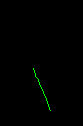

In [80]:
# SKELETONIZING MASK
skeleton = skeletonize(mask)
cv2_imshow(skeleton)

Vervolgens wordt het skelet op verschillende punten gesampled om een verzameling punten te verkrijgen. Deze worden aangeduid met blauwe punten op de mask. Run de code om deze stap uit te voeren.

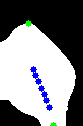

In [81]:
# Finding points along skeleton
aantal = 20
xlist = [top_pixel[0],bottom_pixel[0]]
ylist = [top_pixel[1],bottom_pixel[1]]

for i in range(aantal):
    totaal = 0
    nr = 0
    y = int(i * len(img) / aantal)
    for j in range(len(img[0])):
        if np.array_equal(skeleton[y][j], [0, 255, 0]):
            totaal += j
            nr += 1

    if nr != 0:
        gem = int(totaal / nr)
        xlist.append(gem)
        ylist.append(y)
        cv2.circle(mask_anotated, (gem, y), 3, (255, 0, 0), -1)

xlistnp = np.array(xlist)
ylistnp = np.array(ylist)

cv2_imshow(mask_anotated)

Ten slotte wordt door de gevonden punten de best passende veelterm getrokken. Deze wordt opgesplitst in een aantal lineaire stukken. Hiervan wordt de lengte opgeteld tot de totale lengte in pixels gevonden is. Ook wordt deze gevonden lijn afgebeeld in rood op de foto. Run de code om de laatste stap uit te voeren.

Total length: 107.5 px         Species: PLE


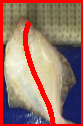

In [82]:
#Fitting polynomial thru points and calculating length

parameters = np.polyfit(ylistnp, xlistnp, 3)

topy = top_pixel[1]
bottomy = bottom_pixel[1]

segments = 10
total_length = 0
for i in range(segments):
    y0 = (bottomy - topy) / segments * i + topy
    y1 = (bottomy - topy) / segments * (i + 1) + topy

    total_length += drawline(y0, y1, parameters, img)

total_length = round(total_length,1)
print("Total length:", total_length, "px", "        Species:",class_list[class_pred])
cv2_imshow(img)


Aangezien deze totale lengte nog in pixels staat zou deze nog moeten omgezet worden in cathesische coördinaten. Deze stap zou uitgevoerd worden door gebruik te maken van de pixelgrootte en de focale afstand.